In [302]:
# imports 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import re
from datetime import datetime as dt
from haversine import haversine
import plotly.express as px
from keplergl import KeplerGl
import geopandas as gpd
# see all columns
pd.set_option('display.max_columns', None)
# set seaborn style
sns.set_style('whitegrid')
# set context to notebook
sns.set_context('notebook')

In [303]:
# read in data
rentals  =  pd.read_csv('../data/processed/donkey_rentals.csv', parse_dates=["StartTime", "EndTime"])

In [304]:
rentals.head()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads
1,2018-03-02 09:55:18.823405,2018-03-02 16:56:35.013,113852,55.687996,12.561522,Ravnsborg,55.687996,12.561522,Ravnsborg
2,2018-03-02 14:00:10.755516,2018-03-02 17:13:08.047,113912,55.682558,12.580462,Møntergade,55.682558,12.580462,Møntergade
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544,113822,55.670289,12.565058,København H - Bus Stops,55.670289,12.565058,København H - Bus Stops
4,2018-03-02 08:51:47.459257,2018-03-02 21:18:48.813,113881,55.680517,12.587455,Nyhavn,55.668475,12.557384,Høkerboderne


In [305]:
rentals.describe()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,latitudeEnd,longitudeEnd
count,255783,255783,255783.000000,255783.000000,255783.000000,255783.000000,255783.000000
mean,2018-10-18 01:44:09.262078720,2018-10-18 11:09:54.439027456,226931.917180,55.678460,12.567270,55.678422,12.567313
min,2018-03-01 08:12:40.421178,2018-03-01 13:54:47.468000,1.000000,50.851039,4.401848,50.851039,4.401848
25%,2018-08-01 12:03:19.637252352,2018-08-01 19:52:41.894000128,163366.000000,55.669027,12.551687,55.669265,12.551687
50%,2018-10-06 10:54:50.052364032,2018-10-06 18:56:36.307696128,233749.000000,55.678067,12.569263,55.678067,12.568931
75%,2019-01-18 09:15:01.774339584,2019-01-18 16:17:24.944292608,295462.000000,55.687694,12.584158,55.687694,12.584117
max,2019-04-02 12:39:57.984950,2019-04-02 12:50:41.606215,357161.000000,55.789327,12.650923,55.789327,12.650923
std,NaN,NaN,79492.926788,0.019814,0.031753,0.019926,0.031891


In [306]:
# Check unique values for the categorical columns: NameStart and nameEnd
unique_name_start = rentals['nameStart'].nunique()
unique_name_end = rentals['nameEnd'].nunique()

unique_name_start, unique_name_end

(1064, 1050)

In [307]:
# Calculate the haversine distance between the starting and ending points
def calculate_distance(row):
    start_coords = (row['latitudeStart'], row['longitudeStart'])
    end_coords = (row['latitudeEnd'], row['longitudeEnd'])
    return haversine(start_coords, end_coords)

rentals['HaversineDistance'] = rentals.apply(calculate_distance, axis=1)

In [308]:
# Extract Month, Day, and StartHour from the StartTime column again
rentals['Month'] = rentals['StartTime'].dt.month_name()
rentals['StartHour'] = rentals['StartTime'].dt.hour

# Add the 'Weekday' column as a string
rentals['Weekday'] = rentals['StartTime'].dt.day_name()
# Calculate the rental duration in minutes
rentals['TripDurationMin'] = (rentals['EndTime'] - rentals['StartTime']).dt.total_seconds() / 60
# create a new column for trip duration in hours
rentals['TripDurationHr'] = rentals['TripDurationMin'] / 60

# create speed column in km/hr based on trip duration and average bike speed of a person
rentals['SpeedKmHr'] = 3.1 / rentals['TripDurationHr']



In [309]:
# describe the TripDurationMin column
rentals['TripDurationMin'].describe()

count    255783.000000
mean        565.752949
std        1552.825657
min       -1361.486435
25%          25.790993
50%         220.745106
75%         591.696032
max      126554.987580
Name: TripDurationMin, dtype: float64

In [310]:
# drop the rentals with negative duration
rentals = rentals[rentals['TripDurationMin'] > 1]

In [311]:
# Calculate the IQR for TripDurationMin
Q1 = rentals['TripDurationMin'].quantile(0.25)
Q3 = rentals['TripDurationMin'].quantile(0.75)
IQR = Q3 - Q1

# Define bounds for outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the outlier trips
outlier_trips = rentals[(rentals['TripDurationMin'] < lower_bound) | (rentals['TripDurationMin'] > upper_bound)]

# Display basic statistics of outlier durations and the first few rows of outlier trips
outlier_statistics = outlier_trips['TripDurationMin'].describe()

In [312]:
outlier_statistics

count     19165.000000
mean       3755.442707
std        4423.182635
min        1442.610004
25%        1998.081537
50%        2826.807031
75%        4081.488476
max      126554.987580
Name: TripDurationMin, dtype: float64

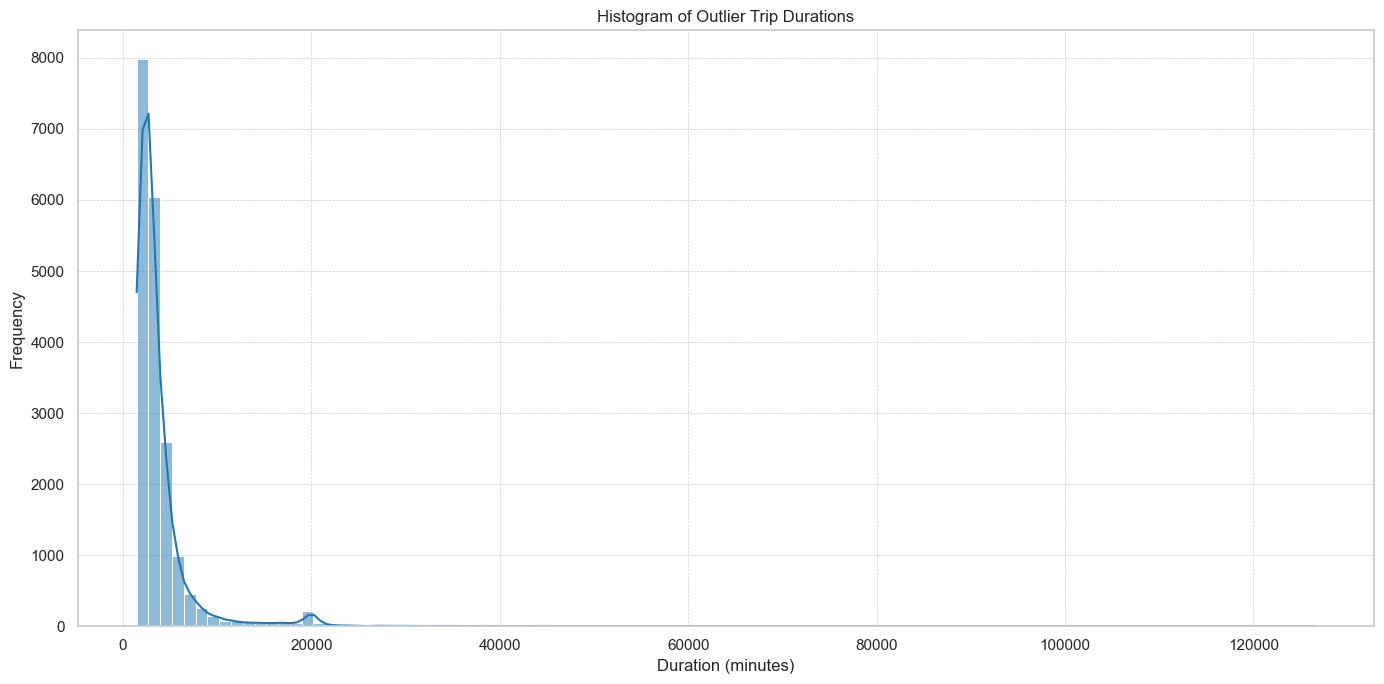

In [313]:
# Plotting a histogram for outlier trip durations
plt.figure(figsize=(14, 7))
sns.histplot(outlier_trips['TripDurationMin'], bins=100, kde=True)
plt.title('Histogram of Outlier Trip Durations')
plt.xlabel('Duration (minutes)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

In [314]:
# Calculate the number of days for each outlier trip
outlier_trips['Days'] = outlier_trips['TripDurationMin'] // 1440  # There are 1440 minutes in a day

# Count the number of trips for each day span
days_distribution = outlier_trips['Days'].value_counts().sort_index()

days_distribution


C:\Users\mihai\AppData\Local\Temp\ipykernel_15600\3353563448.py:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Days
1.0     11225
2.0      4409
3.0      1639
4.0       631
5.0       353
6.0       171
7.0       106
8.0        66
9.0        60
10.0       51
11.0       50
12.0       52
13.0      190
14.0       69
15.0       14
16.0       10
17.0        3
18.0        6
19.0        3
20.0        4
21.0        3
22.0        3
23.0        2
24.0        3
25.0        2
26.0        3
28.0        1
29.0        2
30.0        4
31.0        2
33.0        2
36.0        1
37.0        1
38.0        1
41.0        2
42.0        2
44.0        1
45.0        1
46.0        3
49.0        1
50.0        1
57.0        1
58.0        1
61.0        2
62.0        1
63.0        1
64.0        1
65.0        1
76.0        1
84.0        1
87.0        2
Name: count, dtype: int64

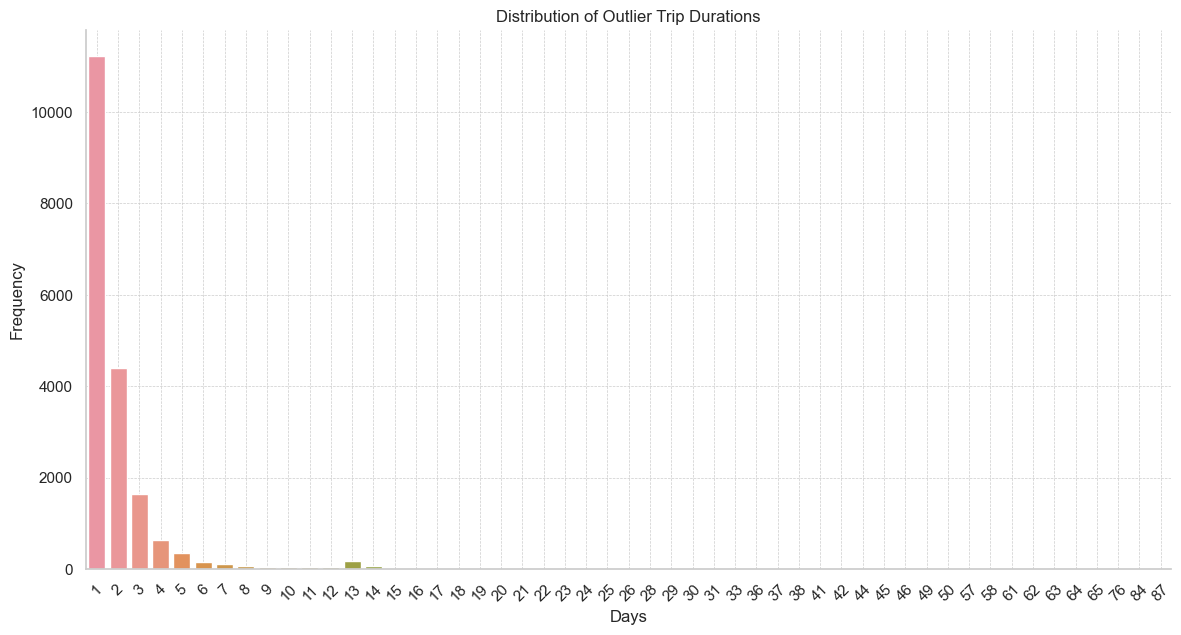

In [315]:
# plot the days_distribution
plt.figure(figsize=(14, 7))
sns.barplot(x=days_distribution.index.astype(np.int64), y=days_distribution.values)
plt.title('Distribution of Outlier Trip Durations')
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(rotation=45)
sns.despine()
plt.show()


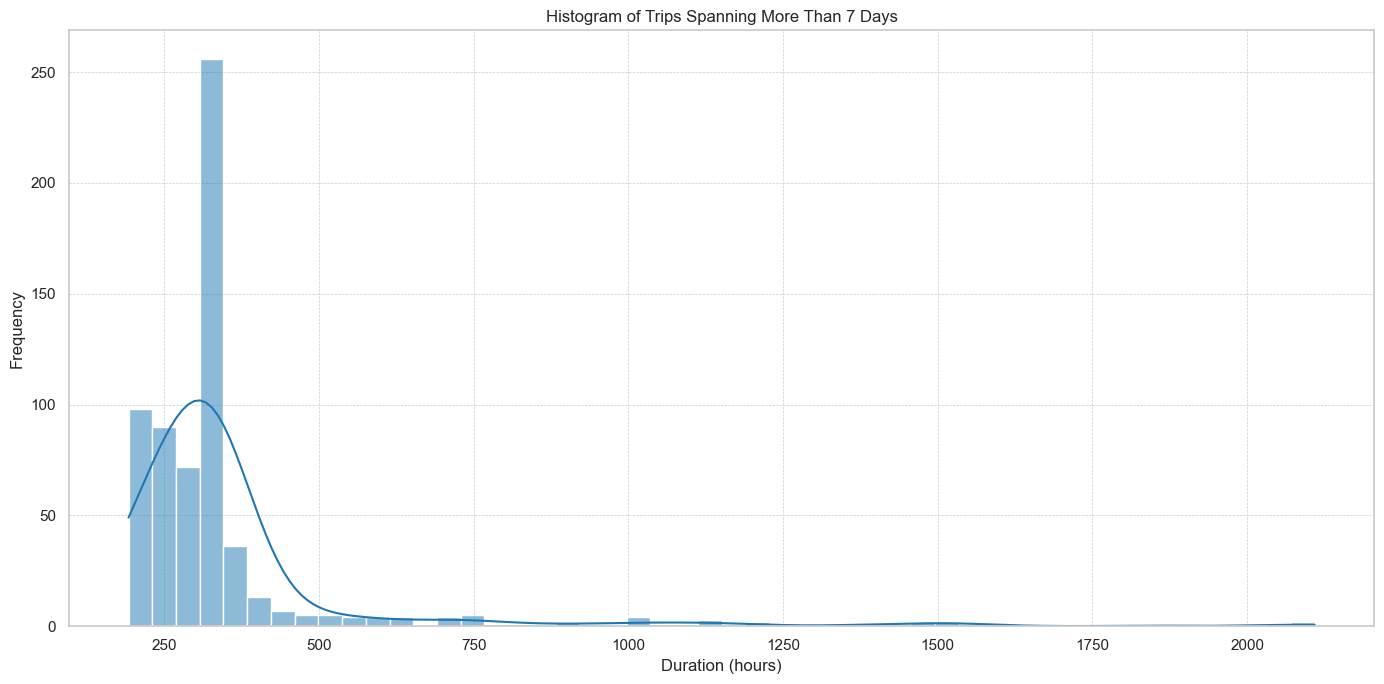

In [316]:
# Filter trips that span more than 7 days
long_duration_trips = outlier_trips[outlier_trips['Days'] > 7]

# Plotting a histogram for these long-duration trips
plt.figure(figsize=(14, 7))
sns.histplot(long_duration_trips['TripDurationHr'], bins=50, kde=True)
plt.title('Histogram of Trips Spanning More Than 7 Days')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [317]:
len(long_duration_trips)

631

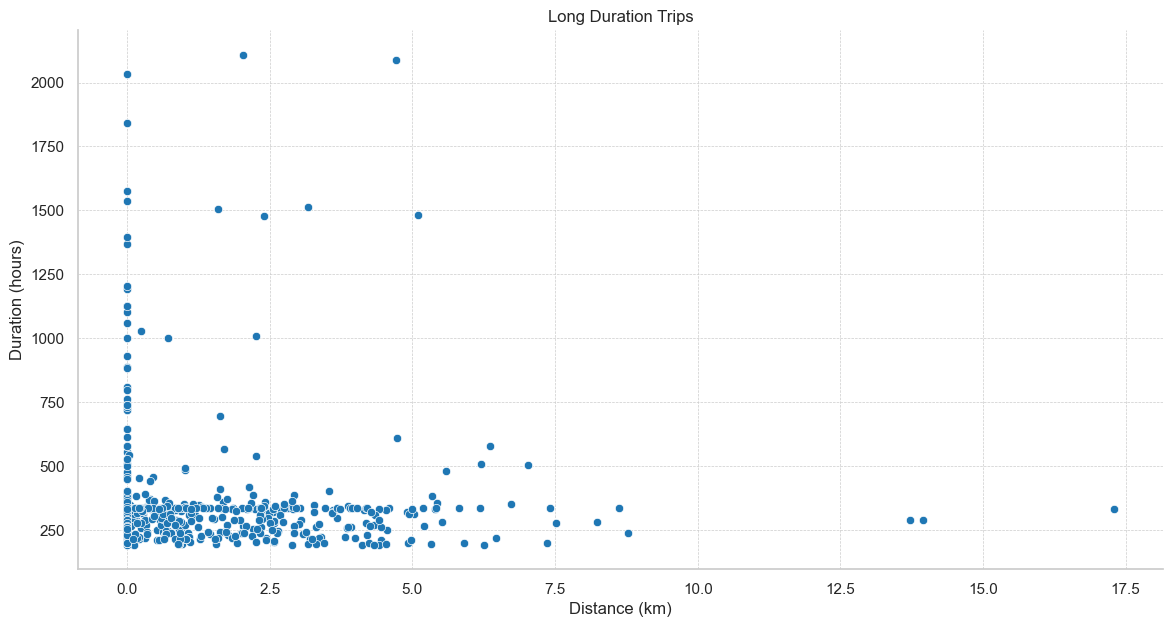

In [318]:
# scatter plot of the long duration in hours vs. the haversine distance
plt.figure(figsize=(14, 7))
sns.scatterplot(x=long_duration_trips['HaversineDistance'], y=long_duration_trips['TripDurationHr'])
plt.title('Long Duration Trips')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
sns.despine()
plt.show()

In [319]:
# print the row of the top 10 longest trips
outlier_trips.sort_values('TripDurationMin', ascending=False).head(10)


,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,Days
60462,2018-05-19 11:02:20.807840,2018-08-15 08:17:20.062634,144681,55.669027,12.579419,Ved Langebro,55.658239,12.605434,Skotlands Plads,2.025133,May,11,Saturday,126554.987580,2109.249793,0.001470,87.0
60463,2018-05-20 08:12:31.631738,2018-08-15 08:17:50.286699,14336,55.667553,12.553189,Litauens Plads,55.709616,12.561689,Sejrøgade,4.707382,May,8,Sunday,125285.310916,2088.088515,0.001485,87.0
26751,2018-04-21 16:35:03.195582,2018-07-15 11:16:49.206618,128376,55.704832,12.537932,Lygten,55.704832,12.537932,Lygten,0.000000,April,16,Saturday,122081.766851,2034.696114,0.001524,84.0
176890,2018-10-22 17:31:23.553629,2019-01-07 13:08:53.611385,267762,55.662698,12.563152,Havnebadet Fisketorvet,55.662698,12.563152,Havnebadet Fisketorvet,0.000000,October,17,Monday,110617.500963,1843.625016,0.001681,76.0
210795,2018-11-02 20:01:57.172792,2019-01-07 13:07:42.627135,303464,55.645486,12.522782,Valbyparken,55.645486,12.522782,Valbyparken,0.000000,November,20,Friday,94625.757572,1577.095960,0.001966,65.0
191764,2018-11-04 12:01:46.816979,2019-01-07 13:06:47.781957,304824,55.677285,12.577430,Gammel Strand,55.677285,12.577430,Gammel Strand,0.000000,November,12,Sunday,92225.016083,1537.083601,0.002017,64.0
116802,2018-07-14 20:39:10.951053,2018-09-15 22:29:51.716007,197543,55.693762,12.541943,Nørrebroparken,55.670371,12.570705,Politigården,3.164771,July,20,Saturday,90830.679416,1513.844657,0.002048,63.0
73170,2018-06-06 15:55:44.900122,2018-08-08 10:06:30.816852,146042,55.672581,12.573892,Ny Carlsberg Glyptotek,55.677731,12.597614,3-Way Bridge,1.593844,June,15,Wednesday,90370.765279,1506.179421,0.002058,62.0
190255,2018-10-27 14:27:19.846342,2018-12-28 09:54:13.154223,224781,55.659138,12.519597,Trekronergade,55.703422,12.541014,Mimersparken,5.103897,October,14,Saturday,89006.888465,1483.448141,0.002090,61.0
40564,2018-04-21 16:35:03.220640,2018-06-22 08:30:52.983862,128380,55.704832,12.537932,Lygten,55.685091,12.553199,Åboulevard,2.394533,April,16,Saturday,88795.829387,1479.930490,0.002095,61.0


In [320]:
# Calculate the number of trips lasting more than 2 weeks (14 days)
two_weeks_minutes = 14 * 24 * 60
long_trips_count = len(rentals[rentals['TripDurationMin'] > two_weeks_minutes])

# Calculate the percentage of these trips compared to the entire dataset
percentage_long_trips = (long_trips_count / len(rentals)) * 100

long_trips_count, percentage_long_trips


(162, 0.06347514673729909)

In [322]:
# create boolean column called RoundTrip
rentals['RoundTrip'] = rentals['nameStart'] == rentals['nameEnd']


In [323]:
rentals.head()

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,RoundTrip
0,2018-03-01 17:43:14.707445,2018-03-01 18:14:12.145,108186,55.673440,12.564409,Central Station,55.658239,12.605434,Skotlands Plads,3.078446,March,17,Thursday,30.957293,0.515955,6.008277,False
1,2018-03-02 09:55:18.823405,2018-03-02 16:56:35.013,113852,55.687996,12.561522,Ravnsborg,55.687996,12.561522,Ravnsborg,0.000000,March,9,Friday,421.269827,7.021164,0.441522,True
2,2018-03-02 14:00:10.755516,2018-03-02 17:13:08.047,113912,55.682558,12.580462,Møntergade,55.682558,12.580462,Møntergade,0.000000,March,14,Friday,192.954858,3.215914,0.963956,True
3,2018-03-01 10:25:34.429934,2018-03-02 20:23:46.544,113822,55.670289,12.565058,København H - Bus Stops,55.670289,12.565058,København H - Bus Stops,0.000000,March,10,Thursday,2038.201901,33.970032,0.091257,True
4,2018-03-02 08:51:47.459257,2018-03-02 21:18:48.813,113881,55.680517,12.587455,Nyhavn,55.668475,12.557384,Høkerboderne,2.312564,March,8,Friday,747.022562,12.450376,0.248988,False


In [324]:
rentals.RoundTrip.value_counts(normalize=True)

RoundTrip
False    0.75977
True     0.24023
Name: proportion, dtype: float64

In [325]:
# calculate nr and percentage of trips longer than 2, 6, 12, 24 hours
# use TripDurationHr column
trip_durations = [3, 9, 16, 24]
trip_counts = []
trip_percentages = []

for duration in trip_durations:
    trips = rentals[rentals['TripDurationHr'] < duration]
    trip_count = len(trips)
    trip_percentage = (trip_count / len(rentals)) * 100
    trip_counts.append(trip_count)
    trip_percentages.append(trip_percentage)
    print(f"Number of trips shorter than {duration} hours: {trip_count}, Percentage: {trip_percentage:.2f}%")



Number of trips shorter than 3 hours: 120388, Percentage: 47.17%
Number of trips shorter than 9 hours: 182759, Percentage: 71.61%
Number of trips shorter than 16 hours: 219923, Percentage: 86.17%
Number of trips shorter than 24 hours: 235815, Percentage: 92.40%


In [326]:
# Drop trips lasting more than 2 weeks
rentals= rentals[rentals['TripDurationMin'] <= two_weeks_minutes]

# Confirm the removal
remaining_long_trips_count = len(rentals[rentals['TripDurationMin'] > two_weeks_minutes])
remaining_long_trips_count


0

# Trips less than 12h


In [327]:
# drop trips lasting more than 12 hours
rentals = rentals[rentals['TripDurationHr'] <= 12]

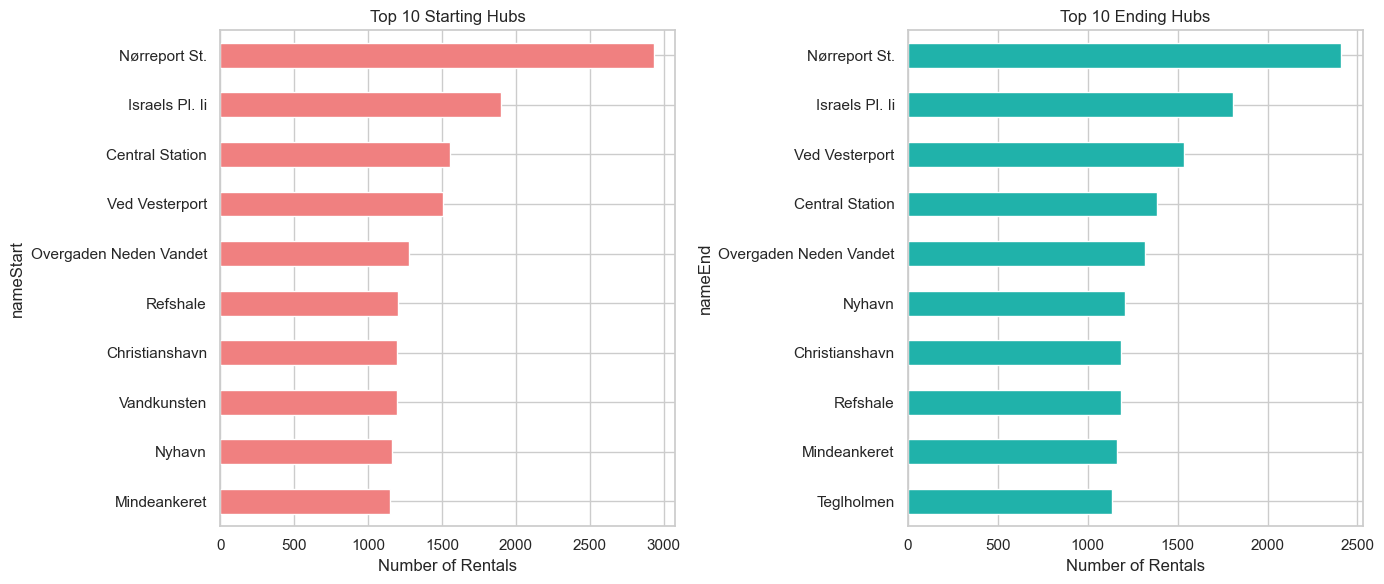

In [328]:
# Top 10 hubs for starting rentals
top_start_hubs = rentals['nameStart'].value_counts().head(10)

# Top 10 hubs for ending rentals
top_end_hubs = rentals['nameEnd'].value_counts().head(10)

plt.figure(figsize=(14, 6))

# Plotting top starting hubs
plt.subplot(1, 2, 1)
top_start_hubs.plot(kind='barh', color='lightcoral')
plt.title('Top 10 Starting Hubs')
plt.xlabel('Number of Rentals')
plt.gca().invert_yaxis()  # To have the hub with the highest count at the top

# Plotting top ending hubs
plt.subplot(1, 2, 2)
top_end_hubs.plot(kind='barh', color='lightseagreen')
plt.title('Top 10 Ending Hubs')
plt.xlabel('Number of Rentals')
plt.gca().invert_yaxis()

plt.tight_layout()
plt.show()


c:\ProgramData\anaconda3\envs\thesis\Lib\site-packages\seaborn\_oldcore.py:1599: UserWarning:

Vertical orientation ignored with only `x` specified.



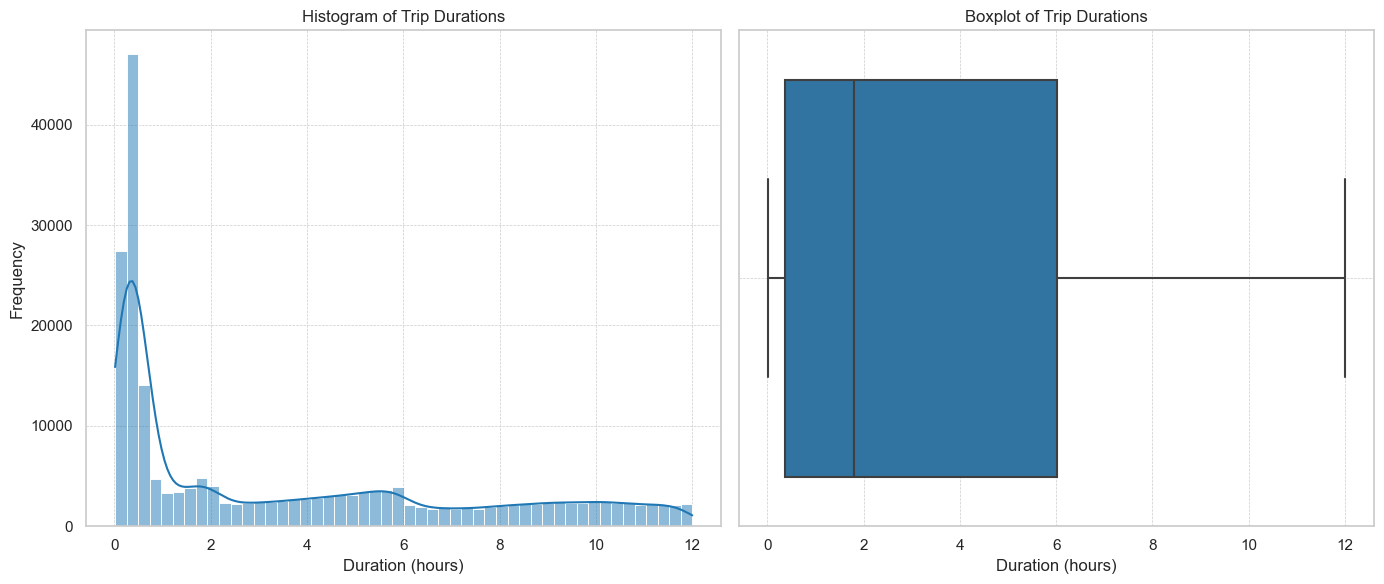

In [329]:
# plot the distribution of the TripDurationHr column using a histogram and a boxplot using subplots

plt.figure(figsize=(14, 6))

# Plotting a histogram
plt.subplot(1, 2, 1)
sns.histplot(rentals['TripDurationHr'], bins=50, kde=True)
plt.title('Histogram of Trip Durations')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Plotting a boxplot
plt.subplot(1, 2, 2)
sns.boxplot(x=rentals['TripDurationHr'], orient='v')
plt.title('Boxplot of Trip Durations')
plt.xlabel('Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.tight_layout()
plt.show()




In [330]:
# Create a combined column representing the route as "StartHub -> EndHub"
rentals['Route'] = rentals['nameStart'] + " -> " + rentals['nameEnd']

# Identify the top 10 most popular routes
top_routes = rentals['Route'].value_counts().head(20)

top_routes


Route
Nørreport St. -> Nørreport St.                        571
Ved Vesterport -> Ved Vesterport                      537
Central Station -> Central Station                    528
Elbagade -> Elbagade                                  422
Vandkunsten -> Vandkunsten                            404
Teglholmen -> Teglholmen                              392
Jarmers Plads -> Jarmers Plads                        380
Bryghusgade -> Bryghusgade                            370
Tycho Brahe Planetarium -> Tycho Brahe Planetarium    353
Strandlodsvej -> Strandlodsvej                        329
Øresund St. -> Øresund St.                            327
Grønjordskollegiet -> Grønjordskollegiet              326
Israels Pl. Ii -> Israels Pl. Ii                      324
Bopa Plads -> Bopa Plads                              319
Peder Hjorts Vej -> Peder Hjorts Vej                  316
Politigården -> Politigården                          309
Aksel Møllers Have -> Aksel Møllers Have              304
Otto Bac

In [331]:
# for each value in top_routes, get the average trip duration
avg_durations = []
for route in top_routes:
    avg_duration = rentals[rentals['Route'] == route]['TripDurationHr'].mean()
    avg_durations.append(avg_duration)

In [332]:
# for each top route, calculate the average trip duration
top_routes_duration = rentals.groupby('Route').aggregate({'TripDurationHr': 'mean'}).sort_values('TripDurationHr', ascending=False).head(20)

In [333]:
top_routes_duration

,TripDurationHr
Route,
Israels Pl. Ii -> Regnbuepladsen,11.997792
Studenterhuset -> Nordhavn St.,11.996621
Kampmannsgade -> Gammeltorv,11.996484
Henrik Ibsens Vej -> Hjørringgade,11.996298
Box -> Øksnehallen,11.996292
Østerport Bike Parking -> Hovedvagtsgade,11.995450
Lygten -> Hulgårds Plads,11.994873
Nørre Farimagsgade -> Tranevej,11.992636
Skank -> Ved Vesterport,11.992252


In [334]:
rentals.StartHour.value_counts().sort_index()

StartHour
0      1945
1      1503
2      1092
3       840
4      1315
5      3986
6     10787
7     15664
8     16941
9     18855
10    17370
11    14182
12    12457
13    12006
14    13218
15    14654
16    12884
17     9907
18     7720
19     6781
20     5624
21     4855
22     3757
23     2942
Name: count, dtype: int64

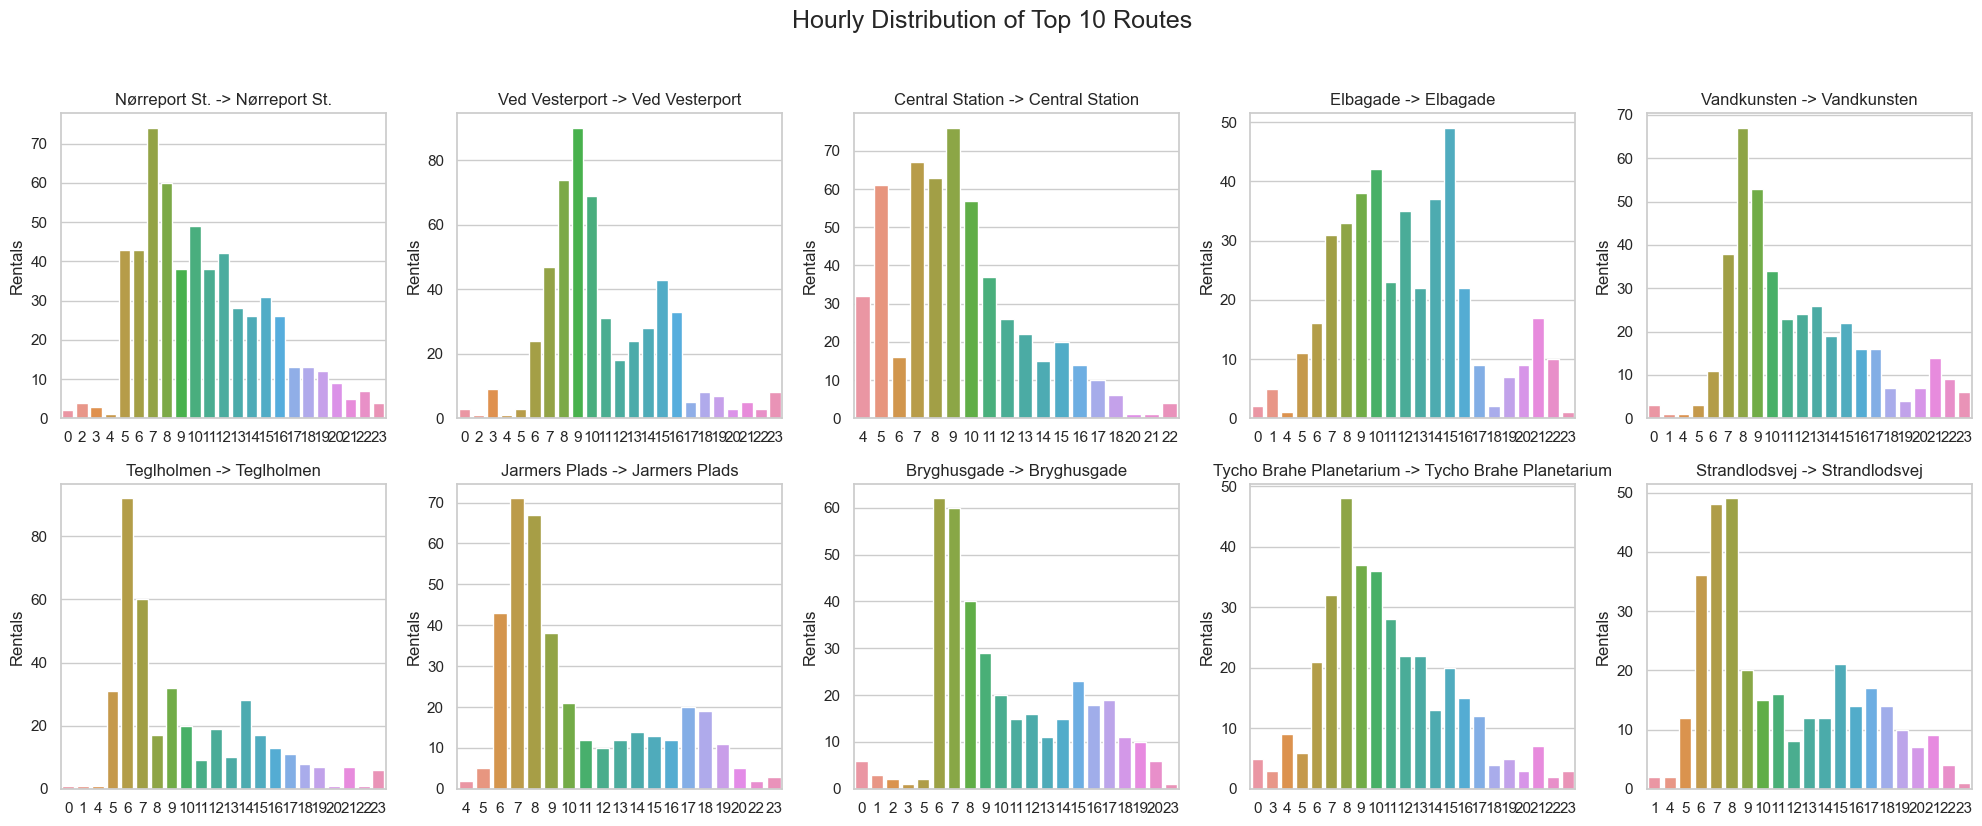

In [335]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a list of the top 10 most popular routes
top_routes = rentals['Route'].value_counts().head(10).index
top_routes_series = rentals['Route'].value_counts().head(10)

# Create a figure with 5 columns and 2 rows
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(20, 8))

# Flatten the axes array
axes = axes.flatten()

# Loop through the top 10 routes and create a countplot for each one
for i, route in enumerate(top_routes):
    route_rentals = rentals[rentals['Route'] == route]
    sns.countplot(x='StartHour', data=route_rentals, ax=axes[i])
    axes[i].set_title(route)
    axes[i].set_xlabel('')
    axes[i].set_ylabel('Rentals')

plt.suptitle('Hourly Distribution of Top 10 Routes', y=1.03, fontsize=18)
plt.tight_layout()
plt.show()


In [336]:
top_routes_series

Route
Nørreport St. -> Nørreport St.                        571
Ved Vesterport -> Ved Vesterport                      537
Central Station -> Central Station                    528
Elbagade -> Elbagade                                  422
Vandkunsten -> Vandkunsten                            404
Teglholmen -> Teglholmen                              392
Jarmers Plads -> Jarmers Plads                        380
Bryghusgade -> Bryghusgade                            370
Tycho Brahe Planetarium -> Tycho Brahe Planetarium    353
Strandlodsvej -> Strandlodsvej                        329
Name: count, dtype: int64

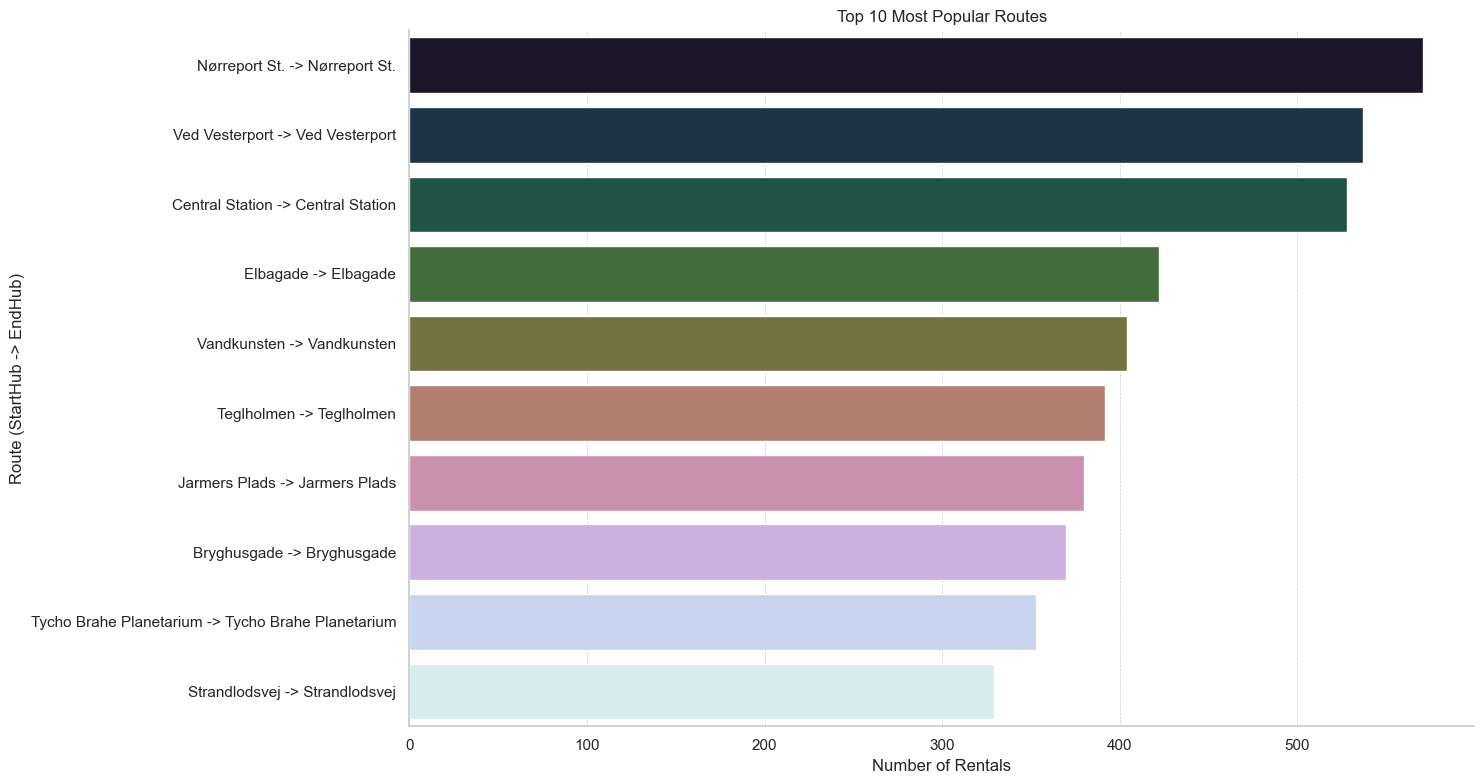

In [337]:
# Plotting the top 10 most popular routes
plt.figure(figsize=(15, 8))
top_routes_plot = sns.barplot(y=top_routes_series.index, x=top_routes_series.values, palette='cubehelix')
plt.title('Top 10 Most Popular Routes')
plt.xlabel('Number of Rentals')
plt.ylabel('Route (StartHub -> EndHub)')
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
sns.despine()
plt.show()


In [338]:
top_routes

Index(['Nørreport St. -> Nørreport St.', 'Ved Vesterport -> Ved Vesterport',
       'Central Station -> Central Station', 'Elbagade -> Elbagade',
       'Vandkunsten -> Vandkunsten', 'Teglholmen -> Teglholmen',
       'Jarmers Plads -> Jarmers Plads', 'Bryghusgade -> Bryghusgade',
       'Tycho Brahe Planetarium -> Tycho Brahe Planetarium',
       'Strandlodsvej -> Strandlodsvej'],
      dtype='object', name='Route')

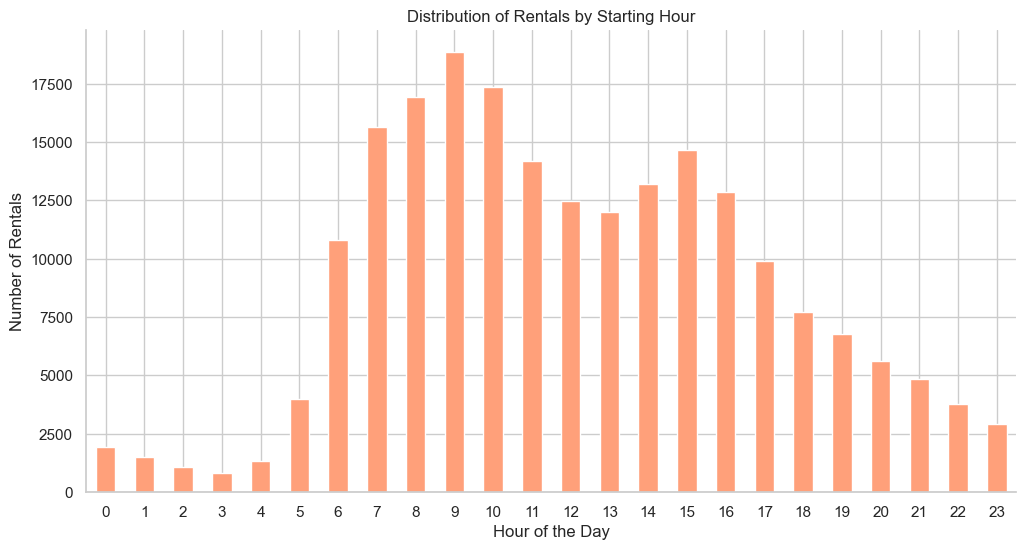

In [339]:
# Distribution of rentals based on starting hour
hourly_rentals = rentals.groupby('StartHour').size()

plt.figure(figsize=(12, 6))
hourly_rentals.plot(kind='bar', color='lightsalmon')
plt.title('Distribution of Rentals by Starting Hour')
plt.ylabel('Number of Rentals')
plt.xlabel('Hour of the Day')
plt.xticks(rotation=0)
sns.despine()
plt.show()


## Hourly Distribution of Rentals

The bar chart showcases the hourly distribution of rentals:

- **Morning Peak:** There is a noticeable peak around 8-9 AM, which corresponds to typical morning commute times.
- **Afternoon-Early Evening Peak:** Another significant peak is observed between 4-6 PM, aligning with evening commute times.
- **Off-Peak Hours:** The early hours (midnight to 5 AM) see the least activity, which is expected as these are typically non-commute and resting hours.
- **Steady Usage:** Throughout the day, there's steady usage of rentals, with a slight dip in the early afternoon.

These patterns align with what we might expect for a public transport system, where users rent bikes for commuting to work or other daily activities.

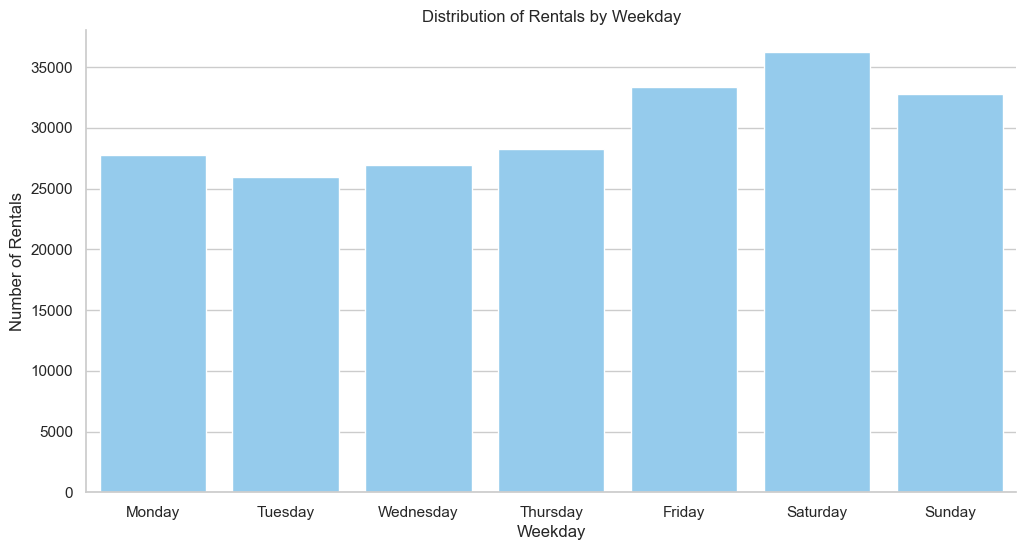

In [340]:
plt.figure(figsize=(12, 6))
sns.countplot(data = rentals, x = 'Weekday', color='lightskyblue', order=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.title('Distribution of Rentals by Weekday')
plt.ylabel('Number of Rentals')
plt.xlabel('Weekday')
plt.xticks(rotation=0)
sns.despine()
plt.show()

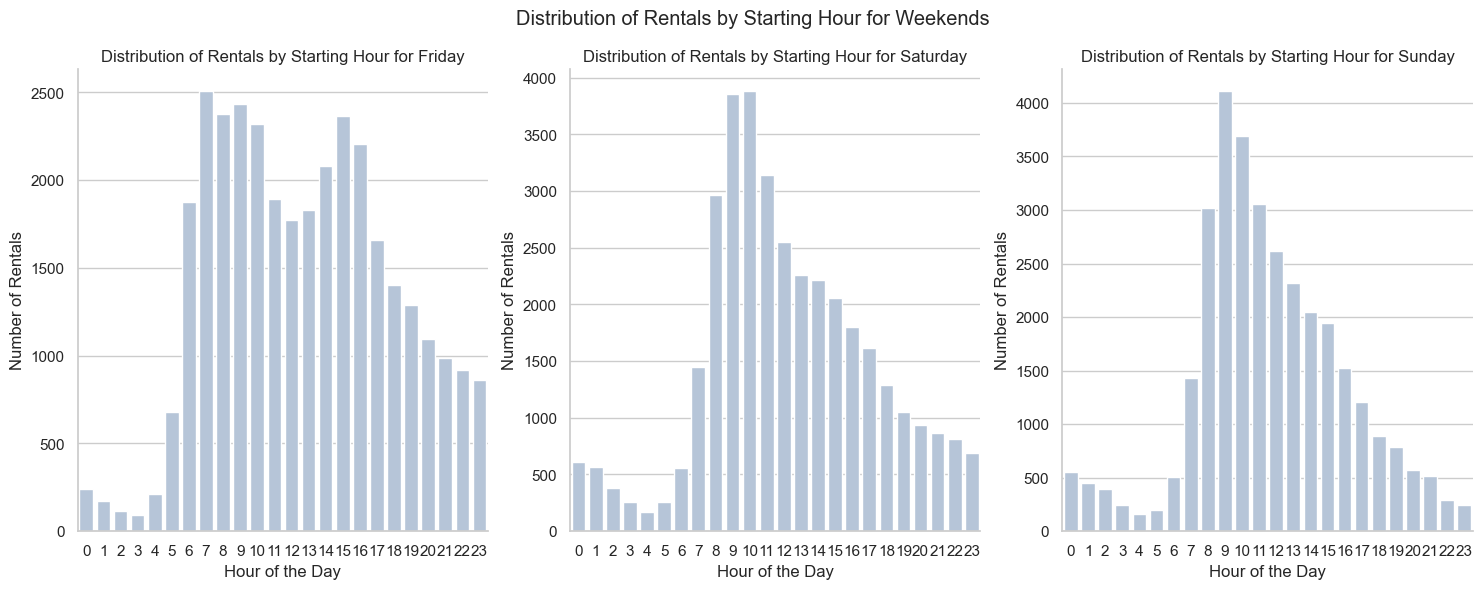

In [341]:
# for Friday, Saturday, and Sunday explore the hourly distribution
weekend_rentals = rentals[rentals['Weekday'].isin(['Friday', 'Saturday', 'Sunday'])]

weekenddays = ['Friday', 'Saturday', 'Sunday']
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, day in enumerate(weekenddays):
    day_rentals = weekend_rentals[weekend_rentals['Weekday'] == day]
    sns.countplot(data=day_rentals, x='StartHour', color='lightsteelblue', ax=axs[i])
    axs[i].set_title(f'Distribution of Rentals by Starting Hour for {day}')
    axs[i].set_ylabel('Number of Rentals')
    axs[i].set_xlabel('Hour of the Day')
    axs[i].set_xticklabels(axs[i].get_xticklabels(), rotation=0)
    sns.despine()

plt.suptitle('Distribution of Rentals by Starting Hour for Weekends')
plt.show()


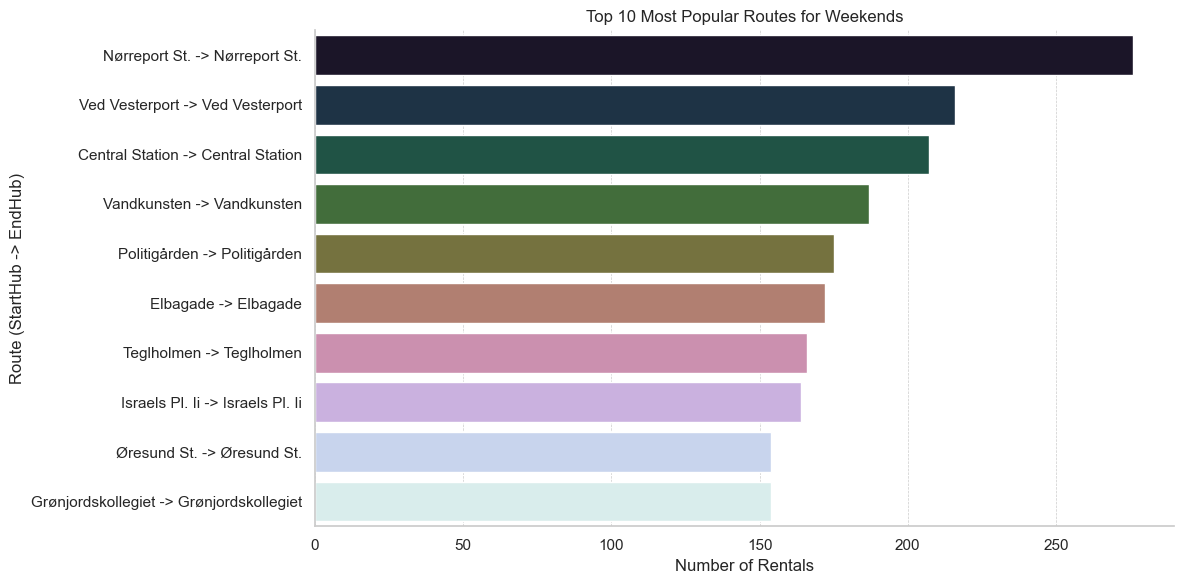

In [342]:
# PLOT THE 10 TOP ROUTES in the weekend 
# Create a list of the top 10 most popular routes
weekend_top_routes = weekend_rentals['Route'].value_counts().head(10).index
weekend_top_routes_series = weekend_rentals['Route'].value_counts().head(10)

# plot the count of each top route
plt.figure(figsize=(12, 6))
weekend_top_routes_plot = sns.barplot(y=weekend_top_routes_series.index, x=weekend_top_routes_series.values, palette='cubehelix')   
plt.title('Top 10 Most Popular Routes for Weekends')
plt.xlabel('Number of Rentals')
plt.ylabel('Route (StartHub -> EndHub)')
plt.grid(axis='x', linestyle='--', linewidth=0.5)
plt.tight_layout()
sns.despine()
plt.show()

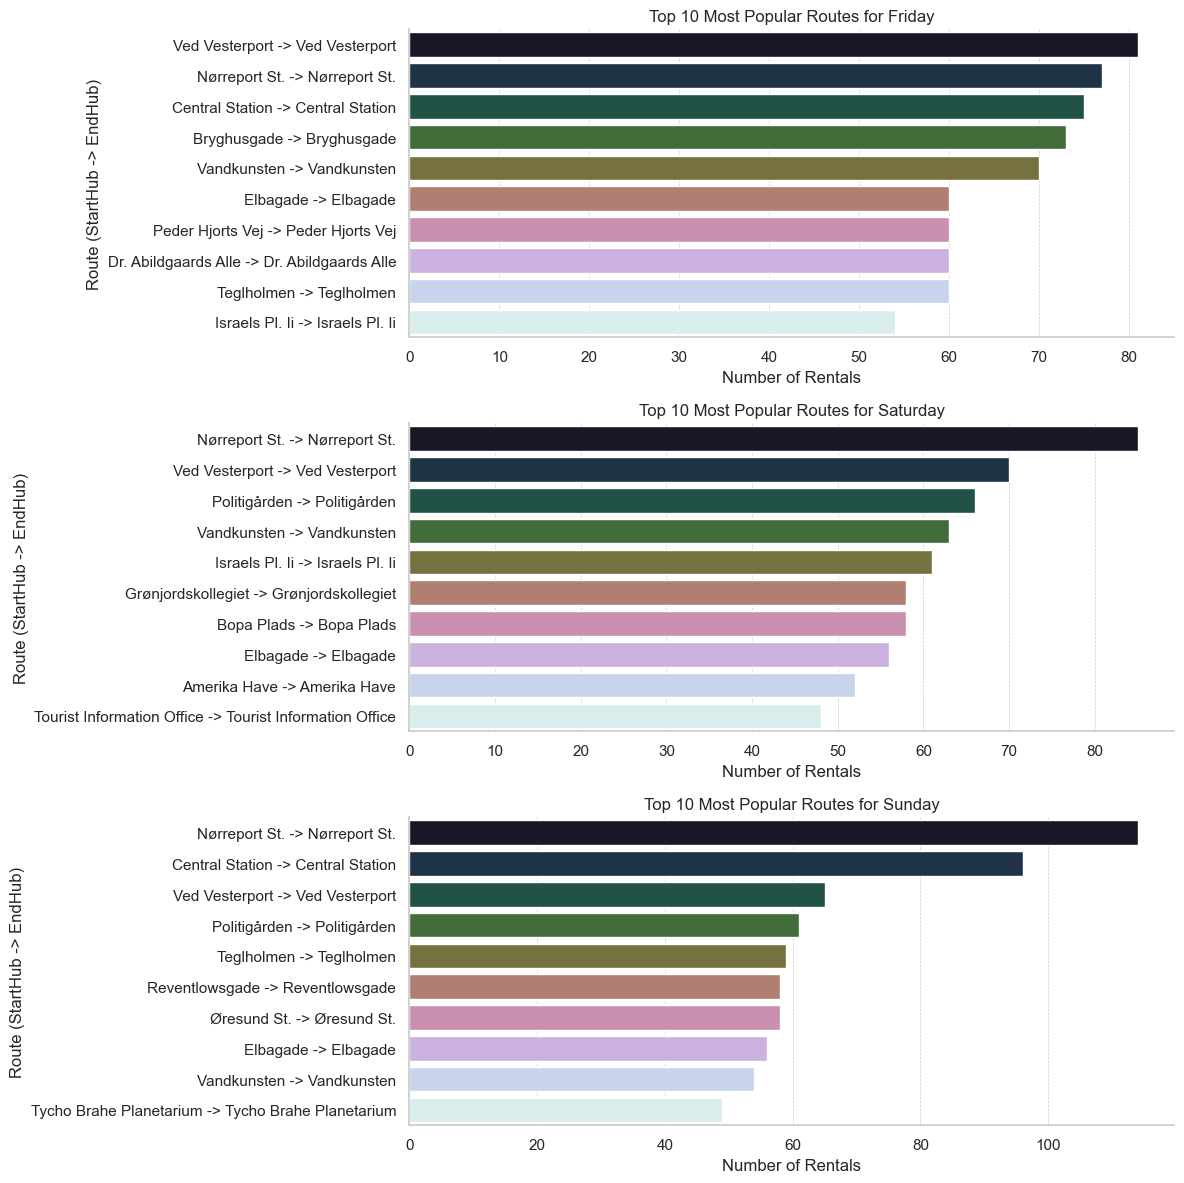

In [343]:
# Create a list of the top 10 most popular routes for each day of the weekend
weekend_top_routes = {}
for day in ['Friday', 'Saturday', 'Sunday']:
    weekend_top_routes[day] = rentals[rentals['Weekday'] == day]['Route'].value_counts().head(10)

# plot the count of each top route for each day of the weekend
fig, axs = plt.subplots(3, 1, figsize=(12, 12))

for i, day in enumerate(['Friday', 'Saturday', 'Sunday']):
    sns.barplot(y=weekend_top_routes[day].index, x=weekend_top_routes[day].values, palette='cubehelix', ax=axs[i])
    axs[i].set_title(f'Top 10 Most Popular Routes for {day}')
    axs[i].set_xlabel('Number of Rentals')
    axs[i].set_ylabel('Route (StartHub -> EndHub)')
    axs[i].grid(axis='x', linestyle='--', linewidth=0.5)
    sns.despine()

# remove the last subplot
#fig.delaxes(axs[1, 1])
plt.tight_layout()

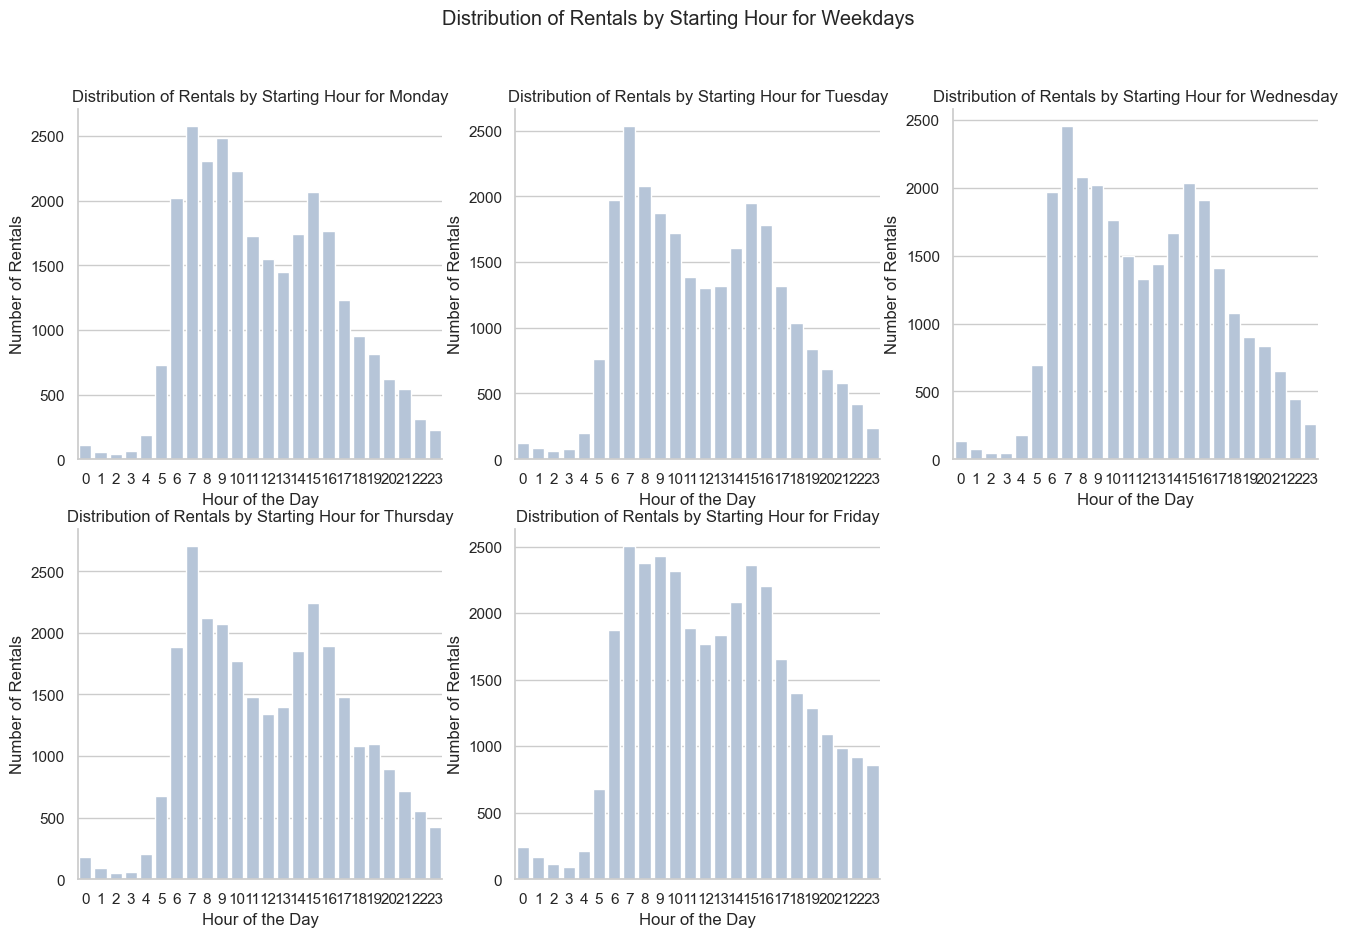

In [344]:
# for Monday to Friday, explore the hourly distribution
weekday_rentals = rentals[rentals['Weekday'].isin(['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday'])]

weekdays = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
fig, axs = plt.subplots(2, 3, figsize=(16, 10))

for i, day in enumerate(weekdays):
    row = i // 3
    col = i % 3
    day_rentals = weekday_rentals[weekday_rentals['Weekday'] == day]
    sns.countplot(data=day_rentals, x='StartHour', color='lightsteelblue', ax=axs[row, col])
    axs[row, col].set_title(f'Distribution of Rentals by Starting Hour for {day}')
    axs[row, col].set_ylabel('Number of Rentals')
    axs[row, col].set_xlabel('Hour of the Day')
    axs[row, col].set_xticklabels(axs[row, col].get_xticklabels(), rotation=0)
    sns.despine()

plt.suptitle('Distribution of Rentals by Starting Hour for Weekdays')
# remove the last subplot
fig.delaxes(axs[1, 2])
plt.show()


In [345]:
# Group by StartTime date (ignoring the time component) and count the rentals
daily_rentals = rentals.groupby(rentals['StartTime'].dt.date).size()

# Plotly interactive plot for Rentals by Date
fig2 = px.line(daily_rentals.reset_index(), x='StartTime', y=0, 
               labels={'0': 'Number of Rentals', 'StartTime': 'Date'},
               title='Rentals by Date')
fig2.update_xaxes(rangeslider_visible=True, tickmode='linear', dtick='M1')
# set size
fig2.update_layout(width= 1000,height=600)

fig2.show()


In [346]:
# create a plotly line figure of number of rentals by month but keeping in mind the year as well
rentals['YearMonth'] = rentals['StartTime'].dt.strftime('%Y-%m')
monthly_rentals = rentals.groupby('YearMonth').size()   

fig3 = px.line(monthly_rentals.reset_index(), x='YearMonth', y=0,
                labels={'0': 'Number of Rentals', 'YearMonth': 'Month'},
                title='Rentals by Month', markers= 'lines+markers')
fig3.update_xaxes(rangeslider_visible=True, tickmode='linear', dtick='M1')
# set figure size
fig3.update_layout(width= 1000,height=600)
fig3.show()





In [347]:
rentals.columns

Index(['StartTime', 'EndTime', 'UserId', 'latitudeStart', 'longitudeStart',
       'nameStart', 'latitudeEnd', 'longitudeEnd', 'nameEnd',
       'HaversineDistance', 'Month', 'StartHour', 'Weekday', 'TripDurationMin',
       'TripDurationHr', 'SpeedKmHr', 'RoundTrip', 'Route', 'YearMonth'],
      dtype='object')

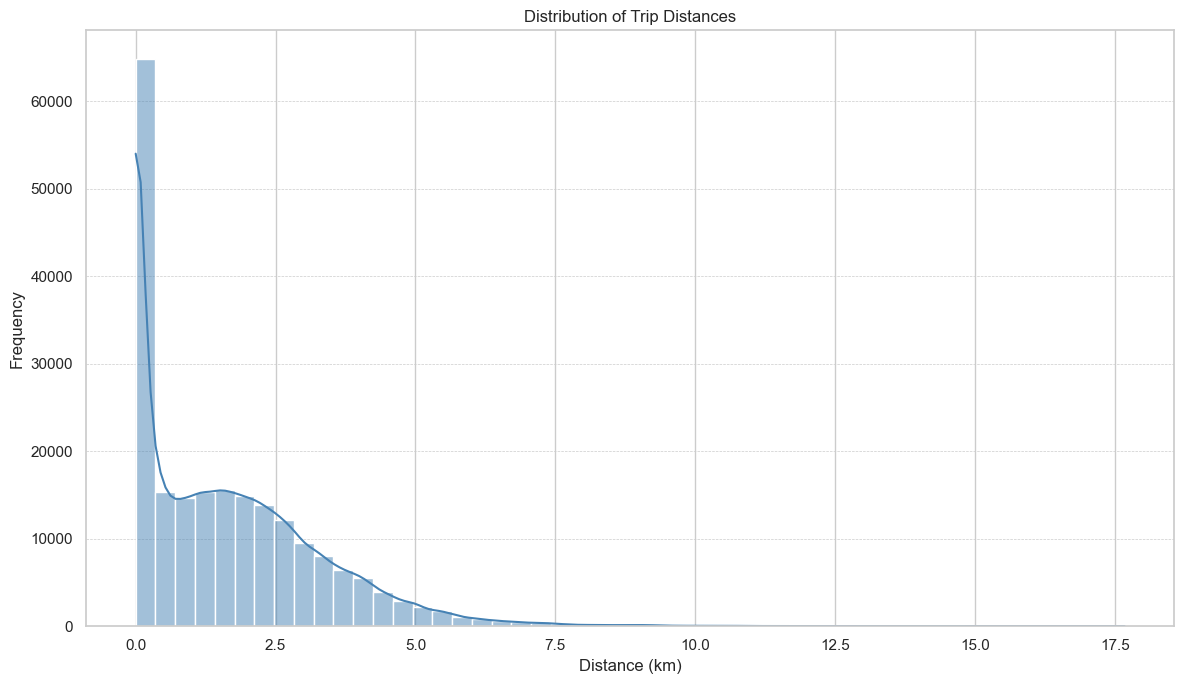

In [348]:
# Plotting the distribution of trip distances using a histogram
plt.figure(figsize=(12, 7))
sns.histplot(rentals['HaversineDistance'], bins=50, kde=True, color="steelblue")
plt.title('Distribution of Trip Distances')
plt.xlabel('Distance (km)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Short Trips: A significant majority of the trips are short, with distances less than 5 km. This suggests that these rentals are primarily used for short commutes, which aligns with the idea of multimodality in public transport.

Peak around 0 km: There's a noticeable peak close to 0 km. This could indicate that many trips are short round trips, where users return to the starting hub, or it could be indicative of short trips between nearby hubs.

Longer Trips: There are a few trips that extend beyond 10 km, but they are relatively less frequent.

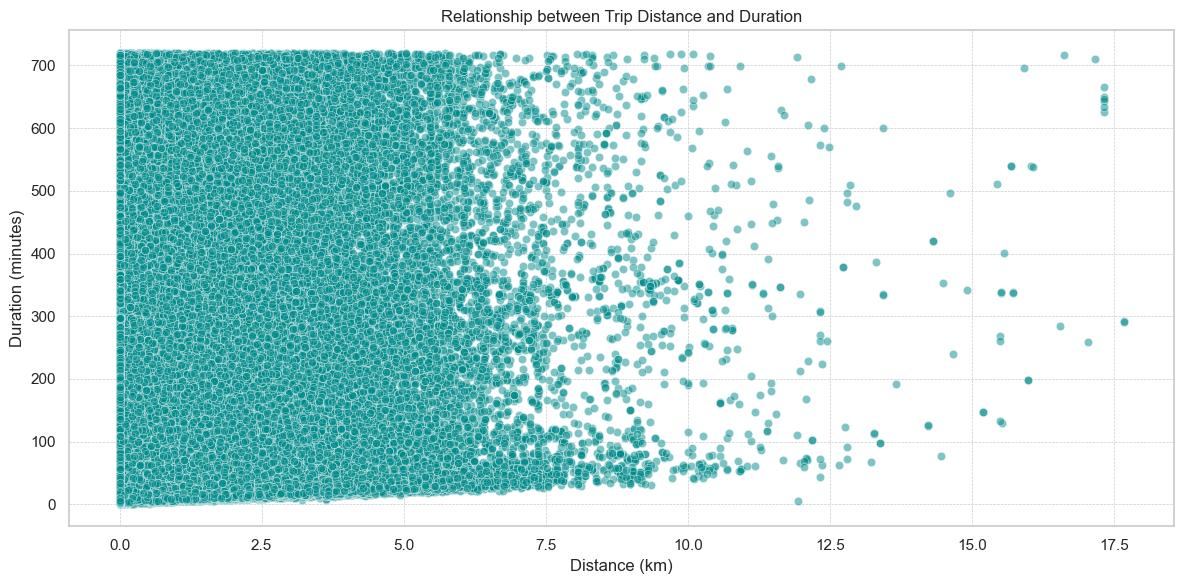

In [349]:
# Scatter plot to visualize the relationship between trip distance and duration
plt.figure(figsize=(12, 6))
sns.scatterplot(data=rentals, x='HaversineDistance', y='TripDurationMin', alpha=0.5, color="darkcyan")
plt.title('Relationship between Trip Distance and Duration')
plt.xlabel('Distance (km)')
plt.ylabel('Duration (minutes)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


Positive Correlation: As expected, there's a general trend indicating that as the trip distance increases, the duration also tends to increase.

Dense Cluster: There's a dense cluster of points in the bottom-left region, indicating many short trips with short durations. This aligns with our earlier observation that most trips are short and are likely used for quick commutes.

Variability: For a given distance, there's variability in trip duration, which could be influenced by factors like traffic, user speed preferences, stops, or detours.

In [350]:
# load cop_area dataset
cop_area = gpd.read_file('../data/processed/cop_area.shp')

In [351]:

# load an empty map
##map_1 = KeplerGl(height=600, width=800)
#map_1

In [352]:
# add data to Kepler map
# map_1.add_data(data=rentals, name='rentals')
# map_1.add_data(data=cop_area, name='cop_area')

In [353]:
rentals.columns

Index(['StartTime', 'EndTime', 'UserId', 'latitudeStart', 'longitudeStart',
       'nameStart', 'latitudeEnd', 'longitudeEnd', 'nameEnd',
       'HaversineDistance', 'Month', 'StartHour', 'Weekday', 'TripDurationMin',
       'TripDurationHr', 'SpeedKmHr', 'RoundTrip', 'Route', 'YearMonth'],
      dtype='object')

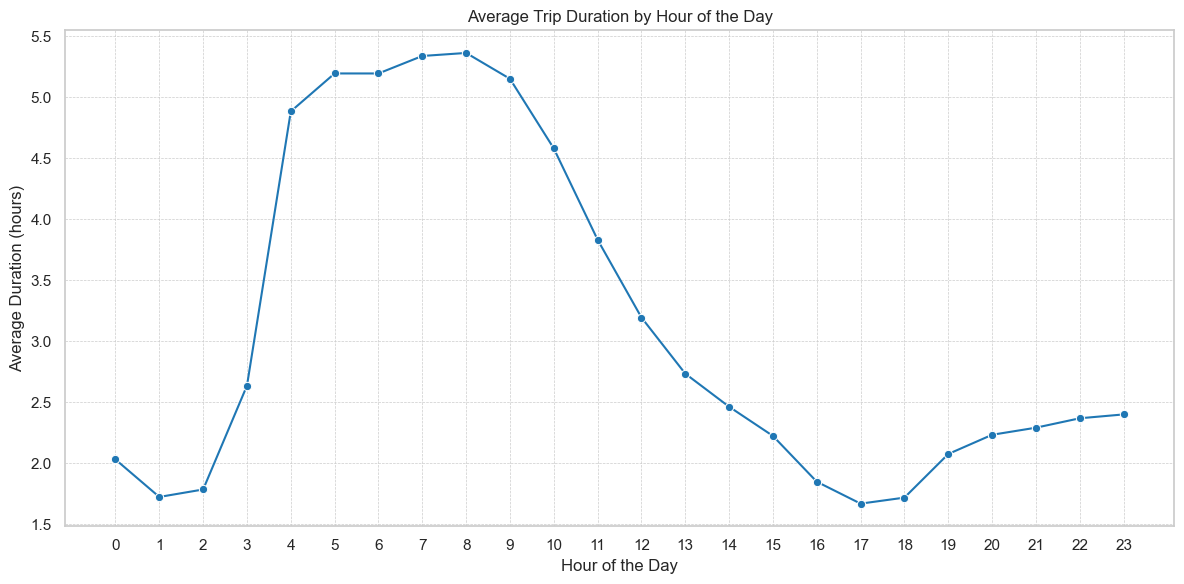

In [354]:
# Filter out trips longer than 12 hours
filtered_rentals = rentals[rentals['TripDurationHr'] <= 12]


# Group the data by StartHour and calculate the average trip duration for each hour
hourly_duration = filtered_rentals.groupby('StartHour')['TripDurationHr'].mean().reset_index()

# Plot the average trip duration by hour of the day
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_duration, x='StartHour', y='TripDurationHr', marker='o')
plt.title('Average Trip Duration by Hour of the Day')
plt.xlabel('Hour of the Day')
plt.ylabel('Average Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


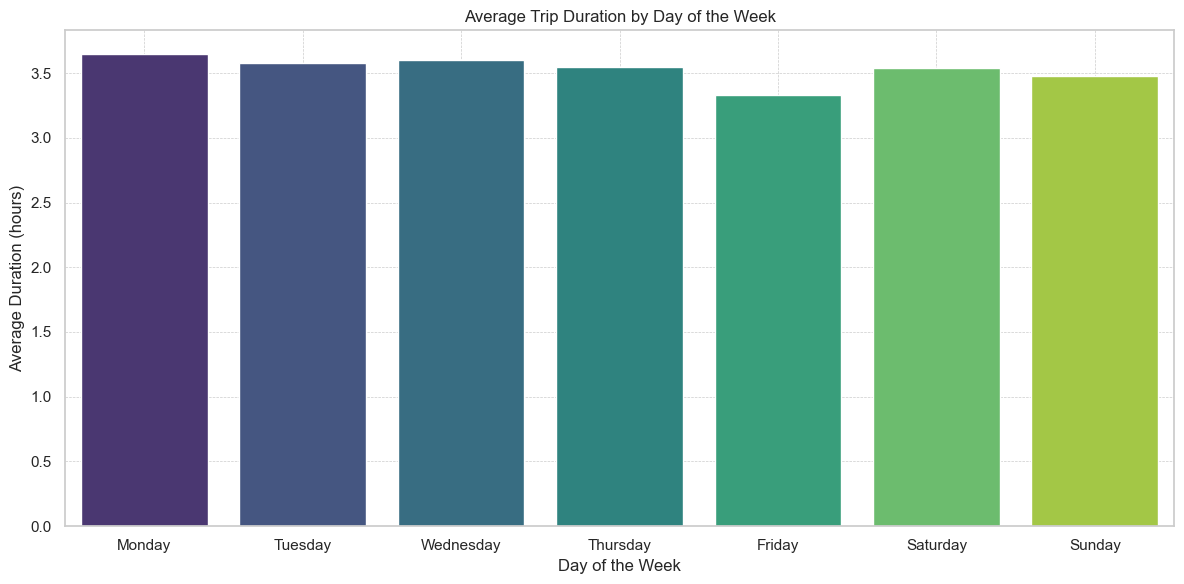

In [355]:
# Create a new column for the day of the week when the trip started
filtered_rentals['StartDayOfWeek'] = filtered_rentals['StartTime'].dt.day_name()

# Order the days of the week for plotting
days_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Group the data by StartDayOfWeek and calculate the average trip duration for each day
daily_duration = filtered_rentals.groupby('StartDayOfWeek')['TripDurationHr'].mean().reindex(days_order).reset_index()

# Plot the average trip duration by day of the week
plt.figure(figsize=(12, 6))
sns.barplot(data=daily_duration, x='StartDayOfWeek', y='TripDurationHr', palette='viridis')
plt.title('Average Trip Duration by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Average Duration (hours)')
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


The bar plot illustrates the average trip duration by day of the week. Here are some key observations:

The average trip duration is relatively consistent across weekdays (Monday to Friday), with a slight increase on Fridays.
There is a noticeable increase in the average trip duration during the weekend (Saturday and Sunday). This could suggest that longer trips are more prevalent on weekends, potentially due to leisure activities or recreational biking.
Implications for Grouping Strategy:
The longer trip durations on weekends suggest that leisure or recreational biking plays a significant role. This should be considered when defining the grouping thresholds, as it indicates that longer trips might not be solely for commuting purposes.
Revised Grouping Suggestion:
Based on the temporal analysis, here's a revised suggestion for grouping trip durations:

Short Trips: 0-1 hours (primarily short commutes or errands)
Medium Trips: 1-3 hours (possibly longer commutes, leisure trips, or errands involving multiple stops)
Long Trips: 3-6 hours (likely recreational or leisure trips, more common on weekends)
Extended Trips: 6-12 hours (special cases, perhaps day-long rentals or bikes kept for convenience)

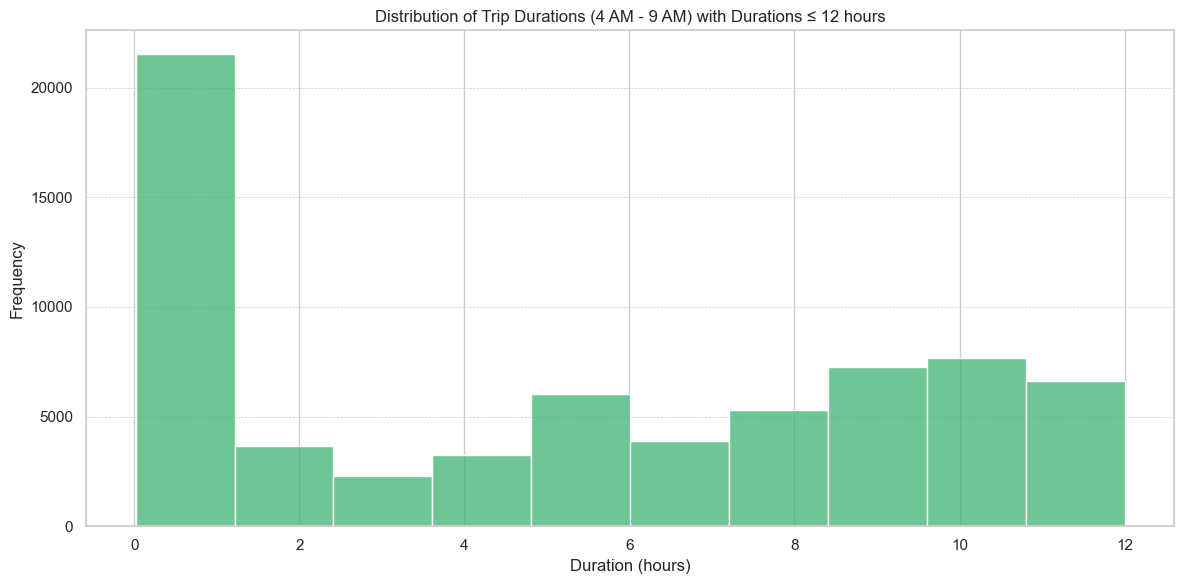

In [356]:
#create morning trips dataframe of trips between 4-9 am
morning_trips = rentals[(rentals['StartHour'] >= 4) & (rentals['StartHour'] <= 9)]
# Further filtering the data to only include trips with a duration less than or equal to 12 hours
morning_trips_filtered = morning_trips[morning_trips['TripDurationHr'] <= 12]

# Plotting a histogram for the TripDurationHr column for the filtered data
plt.figure(figsize=(12, 6))
sns.histplot(data=morning_trips_filtered, x='TripDurationHr', bins=10, color="mediumseagreen")
plt.title('Distribution of Trip Durations (4 AM - 9 AM) with Durations ≤ 12 hours')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


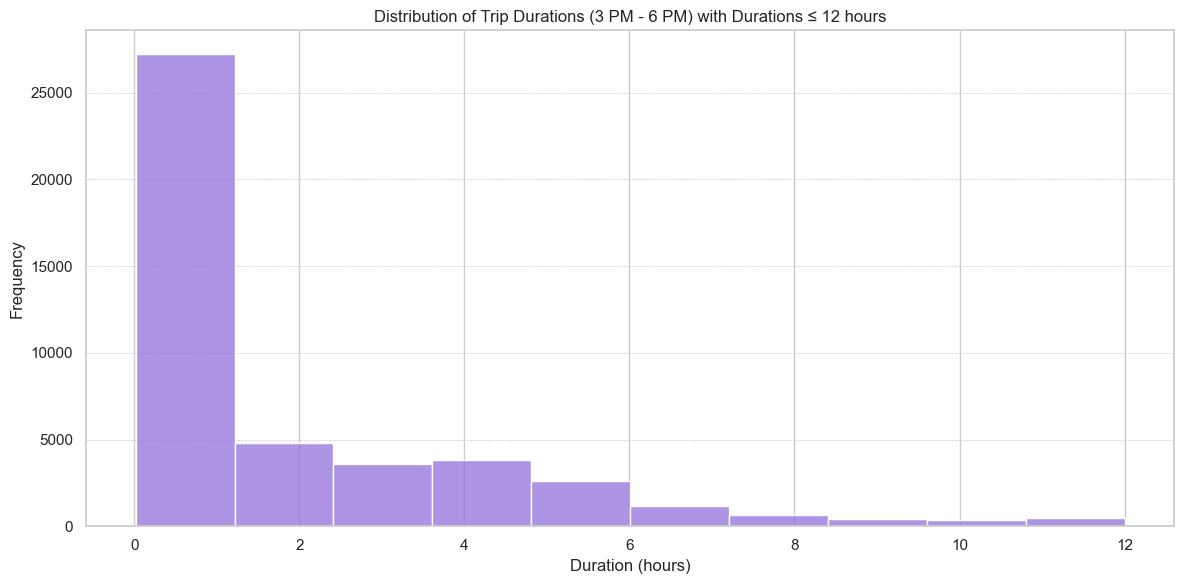

In [357]:
# Filtering the data again to limit the trip duration to 12 hours
afternoon_trips_filtered = rentals[(rentals['StartHour'] >= 15) & (rentals['StartHour'] <= 18) & (rentals['TripDurationHr'] <= 12)]

# Plotting a histogram for the TripDurationHr column with 10 bins
plt.figure(figsize=(12, 6))
sns.histplot(data=afternoon_trips_filtered, x='TripDurationHr', bins=10, color="mediumpurple")
plt.title('Distribution of Trip Durations (3 PM - 6 PM) with Durations ≤ 12 hours')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


In [358]:
# Creating the groups based on the TripDurationHr column
bins = [0, 1, 4, 8, 12]
labels = ['0-1 hour', '1-4 hours', '4-8 hours', '8-12 hours']
rentals['DurationGroup'] = pd.cut(rentals['TripDurationHr'], bins=bins, labels=labels, right=False, ordered=True)

# Displaying the first few rows of the dataset with the new 'DurationGroup' column
rentals[['TripDurationHr', 'DurationGroup']].head()


,TripDurationHr,DurationGroup
0,0.515955,0-1 hour
1,7.021164,4-8 hours
2,3.215914,1-4 hours
5,0.295072,0-1 hour
6,5.672666,4-8 hours


In [359]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211285 entries, 0 to 255782
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   StartTime          211285 non-null  datetime64[ns]
 1   EndTime            211285 non-null  datetime64[ns]
 2   UserId             211285 non-null  int64         
 3   latitudeStart      211285 non-null  float64       
 4   longitudeStart     211285 non-null  float64       
 5   nameStart          211285 non-null  object        
 6   latitudeEnd        211285 non-null  float64       
 7   longitudeEnd       211285 non-null  float64       
 8   nameEnd            211285 non-null  object        
 9   HaversineDistance  211285 non-null  float64       
 10  Month              211285 non-null  object        
 11  StartHour          211285 non-null  int32         
 12  Weekday            211285 non-null  object        
 13  TripDurationMin    211285 non-null  float64      

In [360]:
percentage_duration = rentals.groupby("DurationGroup")["RoundTrip"].mean() * 100
percentage_duration

DurationGroup
0-1 hour       7.058710
1-4 hours     26.895700
4-8 hours     34.778548
8-12 hours    42.860943
Name: RoundTrip, dtype: float64

Percentage of round trips for 0-1 hour: 7.06%
Percentage of round trips for 1-4 hours: 26.90%
Percentage of round trips for 4-8 hours: 34.78%
Percentage of round trips for 8-12 hours: 42.86%


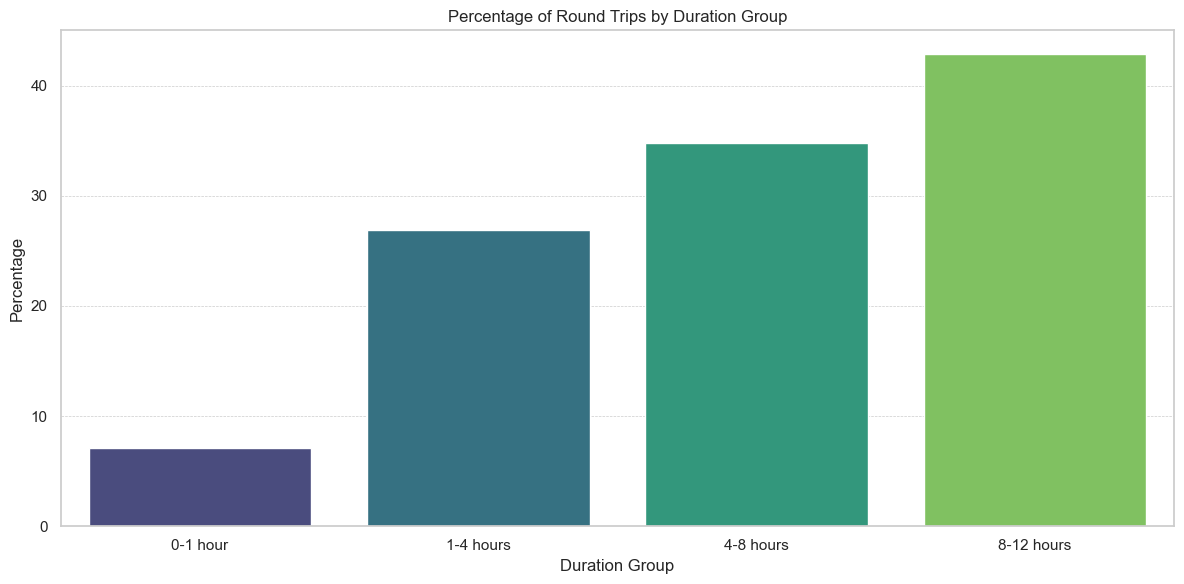

In [361]:
# for each duration group calculate percentage of round trips(which is a bool column)
roundtrip_percentages = []
for label in labels:
    roundtrip_percentage = (rentals[rentals['DurationGroup'] == label]['RoundTrip'].sum() / len(rentals[rentals['DurationGroup'] == label])) * 100
    roundtrip_percentages.append(roundtrip_percentage)
    print(f"Percentage of round trips for {label}: {roundtrip_percentage:.2f}%")

# plod the roundtrip_percentages in the best chart
plt.figure(figsize=(12, 6))
sns.barplot(x=labels, y=roundtrip_percentages, palette='viridis')
plt.title('Percentage of Round Trips by Duration Group')
plt.xlabel('Duration Group')
plt.ylabel('Percentage')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()


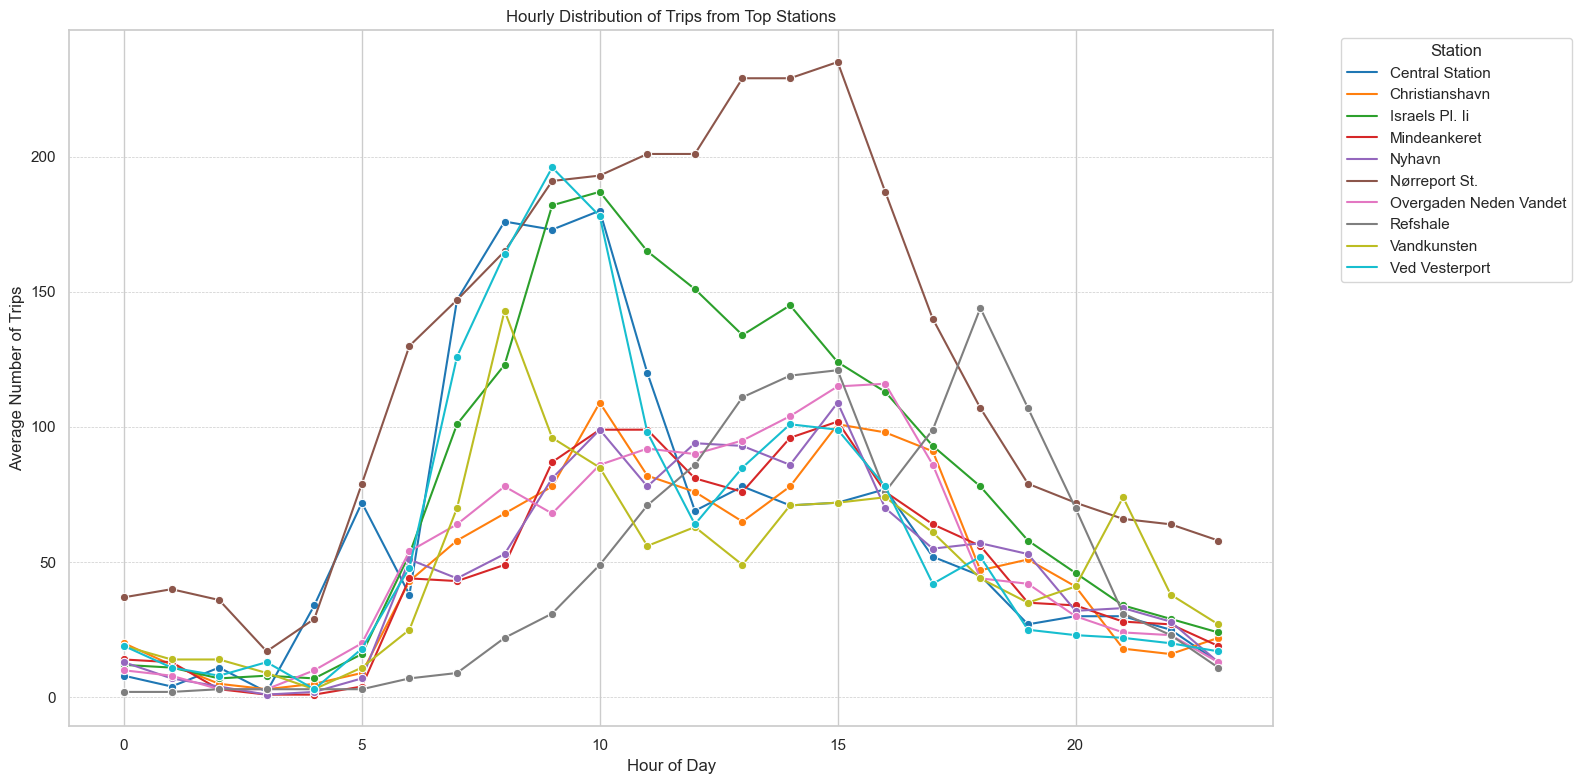

In [362]:
# Analyzing the hourly distribution of trips from the top stations
hourly_distribution = rentals[rentals['nameStart'].isin(top_start_hubs.index)]
hourly_distribution = hourly_distribution.groupby(['nameStart', 'StartHour']).size().reset_index(name='TripCount')

# Plotting the hourly distribution for top stations
plt.figure(figsize=(16, 8))
sns.lineplot(data=hourly_distribution, x='StartHour', y='TripCount', hue='nameStart', marker="o", palette="tab10")
plt.title('Hourly Distribution of Trips from Top Stations')
plt.xlabel('Hour of Day')
plt.ylabel('Average Number of Trips')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.legend(title='Station', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [365]:
# show first row for Israels Pl. Ii nameStart and Norreport St. nameStart
rentals[rentals['nameStart'] == 'Israels Pl. Ii'].head(1)

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,RoundTrip,Route,YearMonth,DurationGroup
247,2018-03-20 07:17:51.913042,2018-03-20 15:34:08.601,115856,55.683292,12.569537,Israels Pl. Ii,55.628975,12.57927,Ørestad St.,6.070511,March,7,Tuesday,496.278133,8.271302,0.37479,False,Israels Pl. Ii -> Ørestad St.,2018-03,8-12 hours


In [366]:
rentals[rentals['nameEnd'] == 'Nørreport St.'].head(1)

,StartTime,EndTime,UserId,latitudeStart,longitudeStart,nameStart,latitudeEnd,longitudeEnd,nameEnd,HaversineDistance,Month,StartHour,Weekday,TripDurationMin,TripDurationHr,SpeedKmHr,RoundTrip,Route,YearMonth,DurationGroup
162,2018-03-15 10:41:23.549453,2018-03-15 18:08:00.660835,37494,55.682597,12.571227,Nørreport St.,55.684305,12.573557,Nørreport St.,0.239623,March,10,Thursday,446.618523,7.443642,0.416463,True,Nørreport St. -> Nørreport St.,2018-03,4-8 hours


In [368]:
# calculate haversine distance between Israeli Plads Ii and Norreport St. (the two most popular stations) in nameStart
station1 = (55.683292, 12.569537)
station2 = (55.682597, 12.571227)
haversine(station1, station2, unit="m")


131.1349926824922